# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/ > /dev/null # no output

지정된 경로를 찾을 수 없습니다.


In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input\bengaliai-cv19\class_map.csv
../input\bengaliai-cv19\sample_submission.csv
../input\bengaliai-cv19\test.csv
../input\bengaliai-cv19\test_image_data_0.parquet
../input\bengaliai-cv19\test_image_data_1.parquet
../input\bengaliai-cv19\test_image_data_2.parquet
../input\bengaliai-cv19\test_image_data_3.parquet
../input\bengaliai-cv19\train.csv
../input\bengaliai-cv19\train_image_data_0.parquet
../input\bengaliai-cv19\train_image_data_1.parquet
../input\bengaliai-cv19\train_image_data_2.parquet
../input\bengaliai-cv19\train_image_data_3.parquet
../input\bengaliaicv19feather\test_image_data_0.feather
../input\bengaliaicv19feather\test_image_data_1.feather
../input\bengaliaicv19feather\test_image_data_2.feather
../input\bengaliaicv19feather\test_image_data_3.feather
../input\bengaliaicv19feather\train_image_data_0.feather
../input\bengaliaicv19feather\train_image_data_1.feather
../input\bengaliaicv19feather\train_image_data_2.feather
../input\bengaliaicv19feather\train_image_data_3.f

In [4]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [5]:
debug=False
submission=False
batch_size=32*4
device='cuda:0'
out='.'
image_size=64*2
arch='pretrained'
model_name='densenet121'

In [6]:
import json

data = {
    "image_size": image_size,
    "threshold": 20.0,
    "arch": "pretrained",
    "model_name": model_name
}

In [7]:
with open(r'./save/args.json', 'w') as f:
    json.dump(data, f, indent=4)

In [8]:
datadir = Path('../input/bengaliai-cv19')
featherdir = Path('../input/bengaliaicv19feather')
outdir = Path('./save')

In [9]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [10]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [11]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
Wall time: 26.5 s


<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np
import cv2

class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        
        
        #x = x.astype(np.float32) / 255.
        #x = x.astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)
        x = x.astype(np.double)
        
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [14]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236, 3) label [15  9  5]


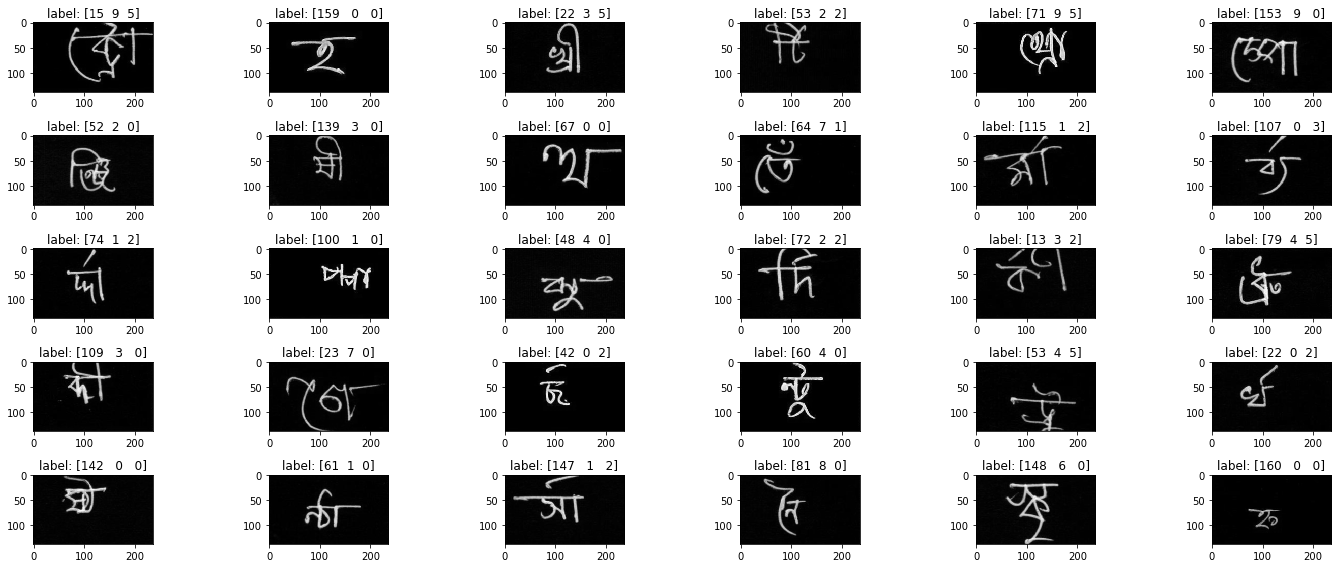

<Figure size 432x288 with 0 Axes>

In [15]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

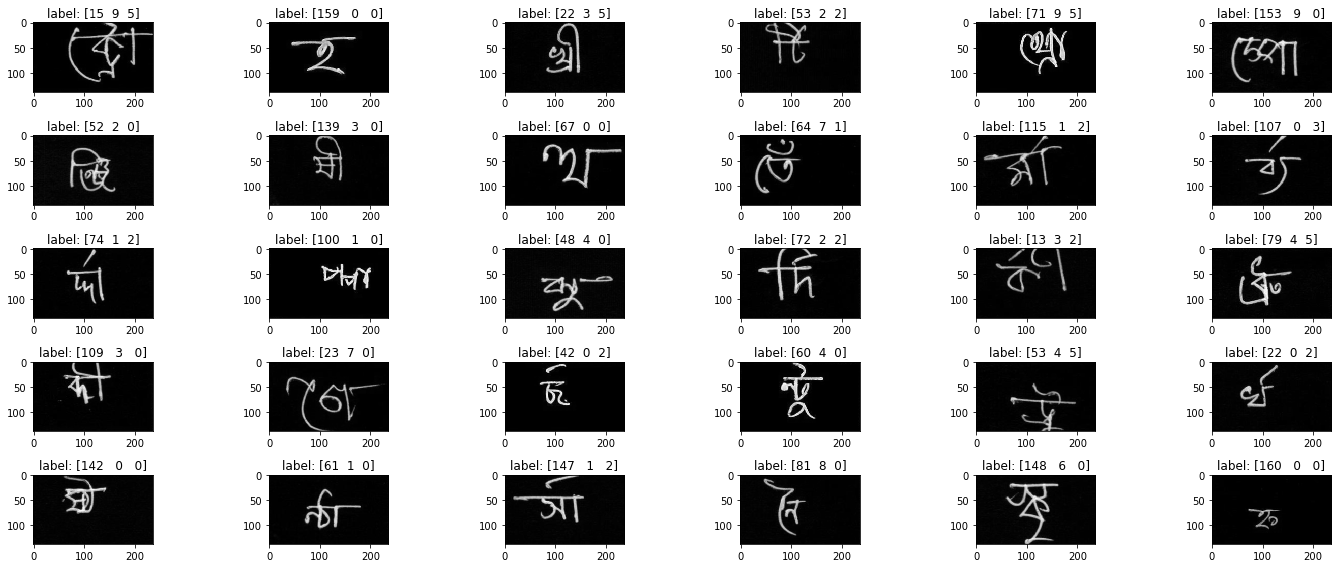

<Figure size 432x288 with 0 Axes>

In [16]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [939]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    #if img.ndim == 3:
    #    img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 15 #7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    #assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def crop_char_image(image, threshold=5./255.):
    #assert image.ndim == 2
    is_black = np.copy(image[:,:,0])
    is_black = is_black > threshold
    is_black[:2,:] = 0
    is_black[-2:,:] = 0
    is_black[:,:2] = 0
    is_black[:,-2:] = 0

    is_black = connected_comp(is_black)

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    
    left = np.argmax(is_black_horizontal)-2
    right = np.argmax(is_black_horizontal[::-1])+2
    top = np.argmax(is_black_vertical)+2
    bottom = np.argmax(is_black_vertical[::-1])-2
    height, width, _ = image.shape
    cropped_image = image[left:height - right, top:width - bottom, :]
    return cropped_image


def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

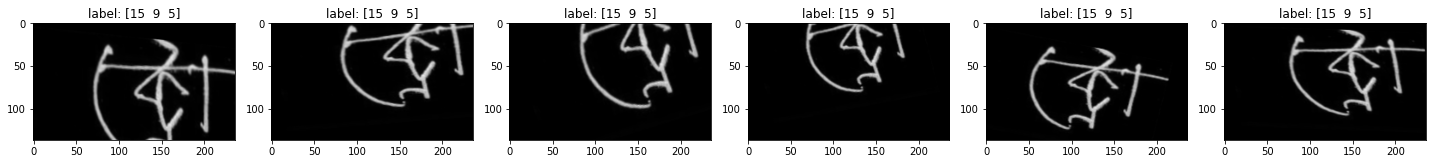

In [940]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

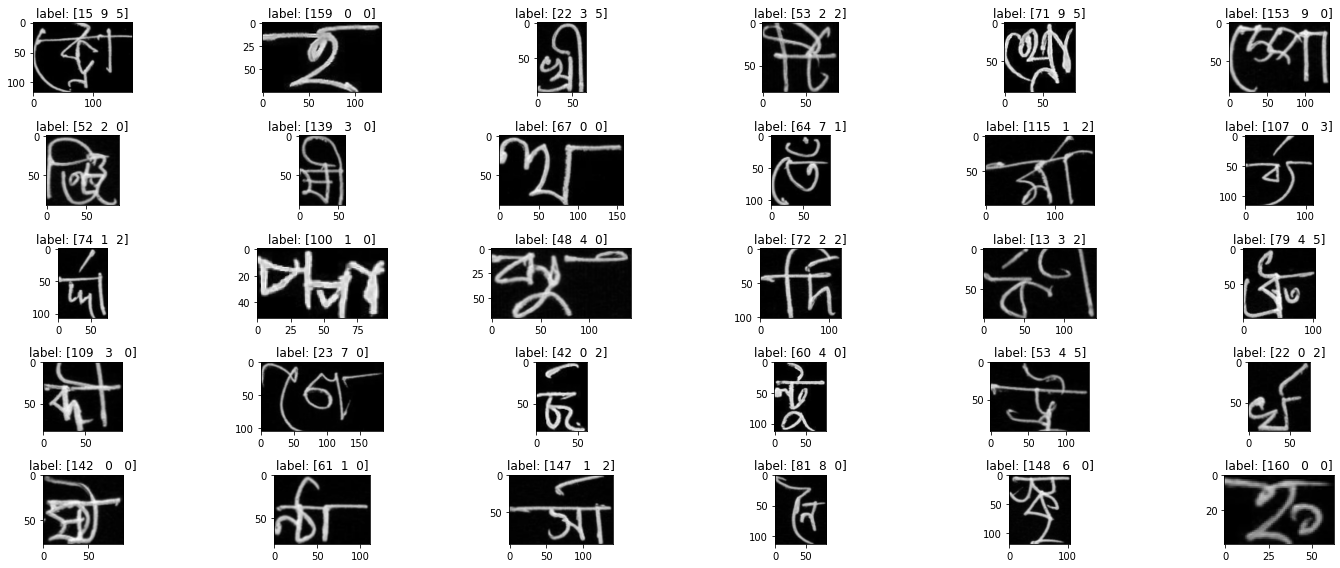

In [941]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(crop_char_image(image, threshold=20./255.), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

In [942]:
train_dataset[6][0].shape

(137, 236, 3)

## resize image

We need to resize image after crop, to align image size for CNN batch training.

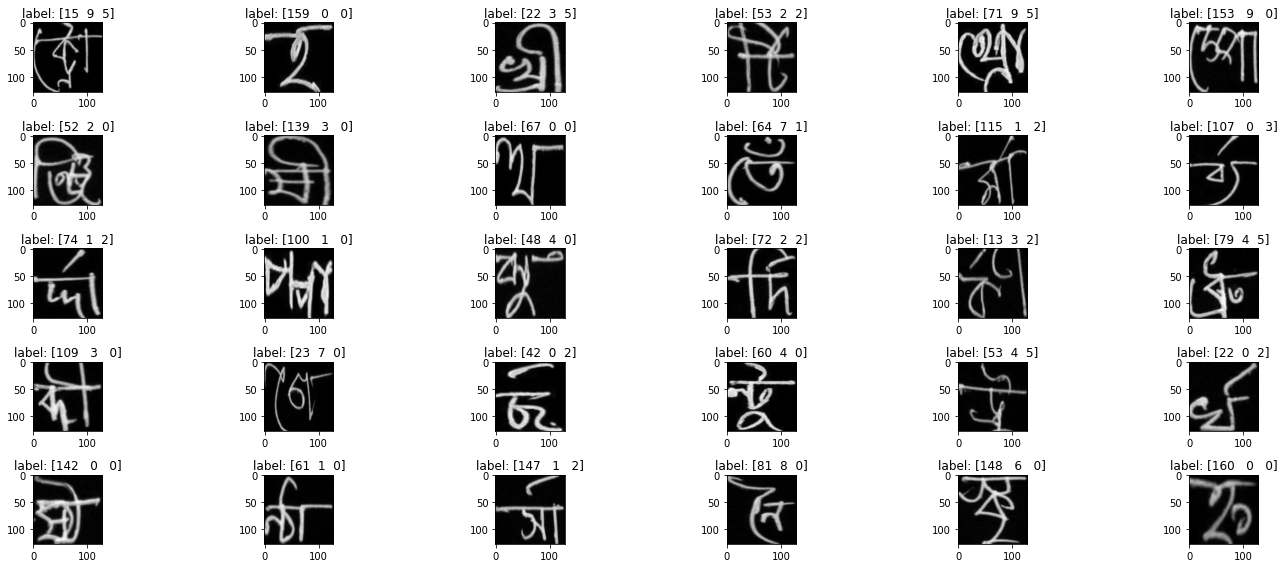

In [943]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(resize(crop_char_image(image, threshold=20./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [944]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            try:
                x = resize(x, size=self.size)
            except:
                print("resize error")
                x, y = example
                x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.double)
        #assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

        if self.normalize:
            x = (x.astype(np.double) - 0.0692) / 0.2051
            
            
        #if x.ndim == 2:
        #    x = x[None, :, :]
        x = np.einsum('ijk->kij', x)
        
        x = x.astype(np.double)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        
# class Transform:
#     def __init__(self, affine=True, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=40.,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
#         if self.train:
#             x, y = example
#         else:
#             x = example
#         # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)

#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
#         if self.size is not None:
#             x = resize(x, size=self.size)
#         if self.sigma > 0.:
#             x = add_gaussian_noise(x, sigma=self.sigma)

#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
#             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             # A.RandomBrightness(p=1.0)  # Deprecated...
#             # A.RandomContrast(p=1.0)    # Deprecated...
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=30,
#                 p=1.0), x)

#         if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.float32)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x
        

In [945]:
train_transform = Transform(
    size=(image_size, image_size), threshold=20.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

In [946]:
# nrow, ncol = 1, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[0]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

In [947]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[i]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [948]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [949]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [950]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [951]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [952]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
            
        return h

## Classifier

In [953]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.9997:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [954]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data

        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data

            
            
        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = loss_grapheme + loss_vowel + loss_consonant  
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = loss_grapheme + loss_vowel + loss_consonant
            
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):

        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                
                
                
                pred = self.predictor(batch)
                
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

In [955]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# from tqdm import tqdm


# def accuracy(y, t):
#     pred_label = torch.argmax(y, dim=1)
#     count = pred_label.shape[0]
#     correct = (pred_label == t).sum().type(torch.double)
#     acc = correct / count
#     return acc


# class BengaliClassifier(nn.Module):
#     def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
#         super(BengaliClassifier, self).__init__()
#         self.n_grapheme = n_grapheme
#         self.n_vowel = n_vowel
#         self.n_consonant = n_consonant
#         self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
#         self.predictor = predictor.float()
        
#         self.metrics_keys = [
#             'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
#             'acc_grapheme', 'acc_vowel', 'acc_consonant']

#     def forward(self, x, y=None):
#         const = np.random.rand()
#         if const<0.4:        
#             # mixup
#             data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#             x = data
#         elif const<0.8:
#             # cutmix
#             data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
#             x = data
#         pred = self.predictor(x)
        
        
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
#         if const<0.8:
#             # cutmix or mixup
#             targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
#             preds1, preds2, preds3 = preds[0], preds[1], preds[2]
#             #loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
#             #loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
#             #loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            
            
#             #criterion = nn.CrossEntropyLoss()
#             #loss_grapheme = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) 
#             #loss_vowel = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
#             #loss_consonant = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
            
            
#             loss = loss_grapheme + loss_vowel + loss_consonant  
            
            
            
            
#         else:
#             loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#             loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#             loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#             loss = loss_grapheme + loss_vowel + loss_consonant
            
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
        
#         return loss, metrics, pred
    
    
    
#     def forward_val(self, x, y=None):

#         pred = self.predictor(x)
        
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
#         loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#         loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#         loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#         loss = loss_grapheme + loss_vowel + loss_consonant
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
        
#         return loss, metrics, pred
    

#     def calc(self, data_loader):
#         device: torch.device = next(self.parameters()).device
#         self.eval()
#         output_list = []
#         with torch.no_grad():
#             for batch in tqdm(data_loader):
#                 # TODO: support general preprocessing.
#                 # If `data` is not `Data` instance, `to` method is not supported!
#                 batch = batch.to(device)
                
                
                
#                 pred = self.predictor(batch)
                
                
#                 output_list.append(pred)
#         output = torch.cat(output_list, dim=0)
#         preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
#         return preds

#     def predict_proba(self, data_loader):
#         preds = self.calc(data_loader)
#         return [F.softmax(p, dim=1) for p in preds]

#     def predict(self, data_loader):
#         preds = self.calc(data_loader)
#         pred_labels = [torch.argmax(p, dim=1) for p in preds]
#         return pred_labels


<a id="train"></a>
# Training code

## prepare data

In [956]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.9)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...

predictor = PretrainedCNN(in_channels=3, out_dim=n_total, model_name=model_name, pretrained=None)
#predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)


perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 180756 valid_dataset 20084
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [957]:
predictor

PretrainedCNN(
  (conv0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _D

## Ignite utility

pytorch-ignite utility class for training

In [958]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        
#         # mixup
#         data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#         #print(data.shape)
#         print(len(targets))
#         print(targets[0].shape)
#         print(y.shape)
        
#         print(targets)
#         print(y)

        
        loss, metrics, pred_y = classifier(x, y)
        
#         print(pred_y.shape)
#         print(pred_y)
#         print("---------------")
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'./save/model_{count:06}.pt',
                 interval=10, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            # self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [959]:
# def create_trainer(classifier, optimizer, device):
#     classifier.to(device)    
#     def update_fn(engine, batch):
#         classifier.train()
#         optimizer.zero_grad()

#         # batch = [elem.to(device) for elem in batch]
#         x, y = [elem.to(device) for elem in batch]        
#         x = x.float()
        
#         print(x.shape)
#         print(y.shape)
        
#         loss, metrics, pred_y = classifier(x, y)

In [960]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))

In [961]:
trainer.run(train_loader, max_epochs=100)

ERROR:ignite.engine.engine.Engine:Current run is terminating due to exception: CUDA error: out of memory.
ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: CUDA error: out of memory.


RuntimeError: CUDA error: out of memory

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

In [962]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [963]:
def build_predictor(arch, out_dim, model_name=None):
    if arch == 'pretrained':
        predictor = PretrainedCNN(in_channels=3, out_dim=out_dim, model_name=model_name)
    else:
        raise ValueError("[ERROR] Unexpected value arch={}".format(arch))
    return predictor


def build_classifier(arch, load_model_path, n_total, model_name='', device='cuda:0'):
    if isinstance(device, str):
        device = torch.device(device)
    predictor = build_predictor(arch, out_dim=n_total, model_name=model_name)
    print('predictor', type(predictor))
    classifier = BengaliClassifier(predictor)
    if load_model_path:
        predictor.load_state_dict(torch.load(load_model_path))
    else:
        print("[WARNING] Unexpected value load_model_path={}"
              .format(load_model_path))
    classifier.to(device)
    return classifier


In [964]:
def predict_core(test_images, image_size, threshold,
                 arch, n_total, model_name, load_model_path, batch_size=512, device='cuda:0', **kwargs):
    classifier = build_classifier(arch, load_model_path, n_total, model_name, device=device)
    

    r"""
    ###############
    n_dataset = len(test_images)
    train_data_size = 200 if debug else int(n_dataset * 0.9)
    valid_data_size = 100 if debug else int(n_dataset - train_data_size)
    
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(size=(image_size, image_size)),
        indices=perm[:train_data_size])
    valid_dataset = BengaliAIDataset(
        train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        )
    print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))
    test_dataset = valid_dataset
    """
    
    test_dataset = BengaliAIDataset(
       test_images, None,
       transform=Transform(affine=False, crop=True, size=(image_size, image_size),
                           threshold=threshold, train=False))
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_pred_proba = classifier.predict_proba(test_loader)
    return test_pred_proba

In [965]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [966]:
# import pretrainedmodels
# import torch
# from torch import nn
# import torch.nn.functional as F
# from torch.nn import Sequential

# class PretrainedCNN(nn.Module):
#     def __init__(self, model_name='densenet121',
#                  in_channels=1, out_dim=10, use_bn=True,
#                  pretrained=None):
#         super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
#         self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
#         activation = F.leaky_relu
#         self.do_pooling = True
#         if self.do_pooling:
#             inch = self.base_model.last_linear.in_features
#         else:
#             inch = None
#         hdim = 512
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

#     def forward(self, x):
#         h = self.conv0(x)
#         h = self.base_model.features(h)

#         if self.do_pooling:
#             h = torch.sum(h, dim=(-1, -2))
#         else:
#             # [128, 2048, 4, 4] when input is (128, 128)
#             bs, ch, height, width = h.shape
#             h = h.view(bs, ch*height*width)
#         for layer in self.lin_layers:
#             h = layer(h)
#         return h

In [967]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# from tqdm import tqdm


# def accuracy(y, t):
#     pred_label = torch.argmax(y, dim=1)
#     count = pred_label.shape[0]
#     correct = (pred_label == t).sum().type(torch.float32)
#     acc = correct / count
#     return acc


# class BengaliClassifier(nn.Module):
#     def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
#         super(BengaliClassifier, self).__init__()
#         self.n_grapheme = n_grapheme
#         self.n_vowel = n_vowel
#         self.n_consonant = n_consonant
#         self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
#         self.predictor = predictor

#         self.metrics_keys = [
#             'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
#             'acc_grapheme', 'acc_vowel', 'acc_consonant']

#     def forward(self, x, y=None):
        
#         pred = self.predictor(x)
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
#         loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#         loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#         loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#         loss = loss_grapheme + loss_vowel + loss_consonant
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
#         return loss, metrics, pred

#     def calc(self, data_loader):
#         device: torch.device = next(self.parameters()).device
#         self.eval()
#         output_list = []
#         with torch.no_grad():
#             for batch in tqdm(data_loader):
#                 # TODO: support general preprocessing.
#                 # If `data` is not `Data` instance, `to` method is not supported!
#                 batch = batch.to(device)
#                 pred = self.predictor(batch)
#                 output_list.append(pred)
#         output = torch.cat(output_list, dim=0)
#         preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
#         return preds

#     def predict_proba(self, data_loader):
#         preds = self.calc(data_loader)
#         return [F.softmax(p, dim=1) for p in preds]

#     def predict(self, data_loader):
#         preds = self.calc(data_loader)
#         pred_labels = [torch.argmax(p, dim=1) for p in preds]
#         return pred_labels


In [968]:
# import numpy as np


# class BengaliAIDataset(DatasetMixin):
#     def __init__(self, images, labels=None, transform=None, indices=None):
#         super(BengaliAIDataset, self).__init__(transform=transform)
#         self.images = images
#         self.labels = labels
#         if indices is None:
#             indices = np.arange(len(images))
#         self.indices = indices
#         self.train = labels is not None

#     def __len__(self):
#         """return length of this dataset"""
#         return len(self.indices)

#     def get_example(self, i):
#         """Return i-th data"""
#         i = self.indices[i]
#         x = self.images[i]
#         # Opposite white and black: background will be white (1.0) and
#         # for future Affine transformation
#         x = (255 - x).astype(np.float32) / 255.
#         if self.train:
#             y = self.labels[i]
#             return x, y
#         else:
#             return x


In [969]:
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            try:
                x = resize(x, size=self.size)
            except:
                print("resize error")
                x, y = example
                x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)
        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        
            
        x = x.astype(np.float32)
        x = np.einsum('ijk->kij', x)
        
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [970]:
# """
# From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
# """
# import cv2
# from skimage.transform import AffineTransform, warp
# import numpy as np


# def affine_image(img):
#     """

#     Args:
#         img: (h, w) or (1, h, w)

#     Returns:
#         img: (h, w)
#     """
#     # ch, h, w = img.shape
#     # img = img / 255.
#     #if img.ndim == 3:
#     #    img = img[0]

#     # --- scale ---
#     min_scale = 0.8
#     max_scale = 1.2
#     sx = np.random.uniform(min_scale, max_scale)
#     sy = np.random.uniform(min_scale, max_scale)

#     # --- rotation ---
#     max_rot_angle = 7
#     rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

#     # --- shear ---
#     max_shear_angle = 10
#     shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

#     # --- translation ---
#     max_translation = 4
#     tx = np.random.randint(-max_translation, max_translation)
#     ty = np.random.randint(-max_translation, max_translation)

#     tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
#                             translation=(tx, ty))
#     transformed_image = warp(img, tform)
#     assert transformed_image.ndim == 2
#     return transformed_image


# from scipy.ndimage.measurements import label

# def connected_comp(array):
    
#     structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
#     labeled, ncomponents = label(array, structure)
    
#     valid = []
#     for i in range(1,ncomponents+1):
#         if np.sum(labeled == i)>10:
#             valid.append(i)

#     new_array = np.zeros(array.shape)
#     for i in valid:
#         new_array += labeled==i
#     return new_array

# def crop_char_image(image, threshold=5./255.):
#     #assert image.ndim == 2
#     is_black = np.copy(image[:,:,0])
#     is_black = is_black > threshold
#     is_black[:2,:] = 0
#     is_black[-2:,:] = 0
#     is_black[:,:2] = 0
#     is_black[:,-2:] = 0

#     is_black = connected_comp(is_black)

#     is_black_vertical = np.sum(is_black, axis=0) > 0
#     is_black_horizontal = np.sum(is_black, axis=1) > 0
    
#     left = np.argmax(is_black_horizontal)-2
#     right = np.argmax(is_black_horizontal[::-1])+2
#     top = np.argmax(is_black_vertical)+2
#     bottom = np.argmax(is_black_vertical[::-1])-2
#     height, width, _ = image.shape
#     cropped_image = image[left:height - right, top:width - bottom, :]
#     return cropped_image

# def resize(image, size=(128, 128)):
#     return cv2.resize(image, size)


In [971]:
# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     )
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

In [972]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.9)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)


perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 180756 valid_dataset 20084
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [973]:
perm_dict = {}
perm_dict[1] = perm[train_data_size:train_data_size+valid_data_size][perm[train_data_size:train_data_size+valid_data_size]<50210]
perm_dict[2] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*2)]-50210
perm_dict[3] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*2<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*3)]-50210*2
perm_dict[4] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*3<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*4)]-50210*3

In [974]:
# 나중에 수정
train2 = train.loc[perm[:train_data_size]]

# define grapheme_dict
grapheme_dict = {}
for gr in tqdm(range(168)):
    df1 = train2[train2['grapheme_root']==gr]    
    df1_pair = df1[['vowel_diacritic','consonant_diacritic']].apply(lambda x: (x['vowel_diacritic'],x['consonant_diacritic']), axis=1)
    df1_ratio = dict(df1_pair.value_counts()/len(df1_pair))
    grapheme_dict[gr] = df1_ratio



  0%|          | 0/168 [00:00<?, ?it/s]

  7%|▋         | 11/168 [00:00<00:01, 107.69it/s]

  9%|▉         | 15/168 [00:00<00:02, 53.72it/s] 

 11%|█▏        | 19/168 [00:00<00:03, 46.07it/s]

 14%|█▎        | 23/168 [00:00<00:03, 41.67it/s]

 16%|█▌        | 27/168 [00:00<00:04, 34.65it/s]

 18%|█▊        | 31/168 [00:00<00:03, 34.63it/s]

 22%|██▏       | 37/168 [00:00<00:03, 38.31it/s]

 24%|██▍       | 41/168 [00:01<00:03, 35.77it/s]

 27%|██▋       | 45/168 [00:01<00:03, 30.86it/s]

 30%|███       | 51/168 [00:01<00:03, 35.63it/s]

 33%|███▎      | 55/168 [00:01<00:03, 33.01it/s]

 35%|███▌      | 59/168 [00:01<00:03, 30.12it/s]

 38%|███▊      | 63/168 [00:01<00:03, 31.47it/s]

 40%|███▉      | 67/168 [00:01<00:03, 27.35it/s]

 43%|████▎     | 72/168 [00:02<00:03, 28.35it/s]

 45%|████▌     | 76/168 [00:02<00:03, 24.45it/s]

 48%|████▊     | 80/168 [00:02<00:03, 23.64it/s]

 49%|████▉     | 83/168 [00:02<00:03, 24.52it/s]

 52%|█████▏    | 87/168 [00:02<00:03, 25.45it/s]

 54%|

In [975]:
from torch.utils.data.dataloader import DataLoader
from chainer_chemistry.utils import save_json, load_json
from tqdm import tqdm

# --- Prediction ---
#traindir = '../input/bengaliaicv19-trainedmodels/'
#data_type = 'predict'
test_preds_list = []

for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        datadir, featherdir, data_type=data_type, submission=submission, indices=indices)
    
    test_images = test_images[perm_dict[i+1]]
    n_dataset = len(test_images)
    print(f'n_dataset={n_dataset}')
    # print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)

    model_preds_list = []
    for j in range(1):
        # --- Depends on train configuration ---
        train_args_dict = load_json(os.path.join('./save/', f'args.json'))
        train_args_dict.update({
            'load_model_path': os.path.join('./save/', f'model_000050.pt'),
            'device': device,
            'batch_size': batch_size,
            'debug': debug,
        })
        print(f'j {j} updated train_args_dict {train_args_dict}')
        test_preds = predict_core(
                test_images=test_images, n_total=n_total,
                **train_args_dict)

        model_preds_list.append(test_preds)

    # --- ensemble ---
    proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
    proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
    proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)

    #p0 = torch.argmax(proba0, dim=1).cpu().numpy()
    p1 = torch.argmax(proba1, dim=1).cpu().numpy()
    p2 = torch.argmax(proba2, dim=1).cpu().numpy()
    
    
    prob_arr0 = np.sort(proba0.cpu().numpy(), axis=1)[:,::-1][:,:3]
    idx_arr0 = np.argsort(proba0.cpu().numpy(), axis=1)[:,::-1][:,:3]
    ratio_arr = np.zeros(idx_arr0.shape)
    
    
    for i in tqdm(range(idx_arr0.shape[0])):
        (vd, cd) = (p1[i], p2[i])
        for j in range(3):
            gr = idx_arr0[i,j]
            #df1 = grapheme_dict[gr] #train[train['grapheme_root']==gr]
            #df1_pair = df1[['vowel_diacritic','consonant_diacritic']].apply(lambda x: (x['vowel_diacritic'],x['consonant_diacritic']), axis=1)
            #ratio = dict(df1_pair.value_counts()).get((vd,cd),0)/len(df1_pair)
            ratio_arr[i, j] = grapheme_dict[gr].get((vd,cd),0)
    
    # 기본형
    #p0 = idx_arr0[:,0]
    
    # 확률
    #prob_p0 = prob_arr0[:,0]
    

    beta = 0.01
    ratio_arr = ratio_arr>beta
    
    # 순서결과 
    alpha = 0.7
    prob_arr0 = prob_arr0 + alpha * ratio_arr #alpha * np.multiply(prob_arr0, ratio_arr)
    rank_list = []
    for i,j in enumerate(np.argsort(prob_arr0,axis=1)[:,2]):
        rank_list.append(idx_arr0[i, j])

    p0 = np.array(rank_list)
    print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

    test_preds_list.append([p0, p1, p2])
    if debug:
        break
    #del test_images
    gc.collect()

image_df_list 1
n_dataset=5066
j 0 updated train_args_dict {'image_size': 128, 'threshold': 20.0, 'arch': 'pretrained', 'model_name': 'densenet121', 'load_model_path': './save/model_000050.pt', 'device': device(type='cuda', index=0), 'batch_size': 128, 'debug': False}
predictor <class '__main__.PretrainedCNN'>




  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:00<00:05,  7.79it/s]

test_dataset 5066




  5%|▌         | 2/40 [00:00<00:04,  7.73it/s]

  8%|▊         | 3/40 [00:00<00:04,  7.72it/s]

 10%|█         | 4/40 [00:00<00:04,  7.74it/s]

 12%|█▎        | 5/40 [00:00<00:04,  7.75it/s]

 15%|█▌        | 6/40 [00:00<00:04,  7.79it/s]

 18%|█▊        | 7/40 [00:00<00:04,  7.73it/s]

 20%|██        | 8/40 [00:01<00:04,  7.87it/s]

 22%|██▎       | 9/40 [00:01<00:03,  7.93it/s]

 25%|██▌       | 10/40 [00:01<00:03,  7.93it/s]

 28%|██▊       | 11/40 [00:01<00:03,  7.97it/s]

 30%|███       | 12/40 [00:01<00:03,  7.79it/s]

 32%|███▎      | 13/40 [00:01<00:03,  7.80it/s]

 35%|███▌      | 14/40 [00:01<00:03,  7.97it/s]

 38%|███▊      | 15/40 [00:01<00:03,  8.06it/s]

 40%|████      | 16/40 [00:02<00:02,  8.13it/s]

 42%|████▎     | 17/40 [00:02<00:02,  8.21it/s]

 45%|████▌     | 18/40 [00:02<00:02,  8.24it/s]

 48%|████▊     | 19/40 [00:02<00:02,  8.18it/s]

 50%|█████     | 20/40 [00:02<00:02,  8.28it/s]

 52%|█████▎    | 21/40 [00:02<00:02,  8.31it/s]

 55%|█████▌    | 22/40 [00

p0 (5066,) p1 (5066,) p2 (5066,)
image_df_list 1
n_dataset=4990
j 0 updated train_args_dict {'image_size': 128, 'threshold': 20.0, 'arch': 'pretrained', 'model_name': 'densenet121', 'load_model_path': './save/model_000050.pt', 'device': device(type='cuda', index=0), 'batch_size': 128, 'debug': False}




  0%|          | 0/39 [00:00<?, ?it/s]

predictor <class '__main__.PretrainedCNN'>
test_dataset 4990




  3%|▎         | 1/39 [00:00<00:04,  8.13it/s]

  5%|▌         | 2/39 [00:00<00:04,  8.12it/s]

  8%|▊         | 3/39 [00:00<00:04,  8.11it/s]

 10%|█         | 4/39 [00:00<00:04,  8.05it/s]

 13%|█▎        | 5/39 [00:00<00:04,  8.14it/s]

 15%|█▌        | 6/39 [00:00<00:04,  8.17it/s]

 18%|█▊        | 7/39 [00:00<00:03,  8.24it/s]

 21%|██        | 8/39 [00:00<00:03,  8.13it/s]

 23%|██▎       | 9/39 [00:01<00:03,  8.21it/s]

 26%|██▌       | 10/39 [00:01<00:03,  8.22it/s]

 28%|██▊       | 11/39 [00:01<00:03,  8.18it/s]

 31%|███       | 12/39 [00:01<00:03,  7.88it/s]

 33%|███▎      | 13/39 [00:01<00:03,  8.05it/s]

 36%|███▌      | 14/39 [00:01<00:03,  8.11it/s]

 38%|███▊      | 15/39 [00:01<00:03,  7.92it/s]

 41%|████      | 16/39 [00:01<00:02,  8.05it/s]

 44%|████▎     | 17/39 [00:02<00:02,  7.93it/s]

 46%|████▌     | 18/39 [00:02<00:02,  8.00it/s]

 49%|████▊     | 19/39 [00:02<00:02,  8.12it/s]

 51%|█████▏    | 20/39 [00:02<00:02,  8.07it/s]

 54%|█████▍    | 21/39 [00:

p0 (4990,) p1 (4990,) p2 (4990,)
image_df_list 1
n_dataset=5033
j 0 updated train_args_dict {'image_size': 128, 'threshold': 20.0, 'arch': 'pretrained', 'model_name': 'densenet121', 'load_model_path': './save/model_000050.pt', 'device': device(type='cuda', index=0), 'batch_size': 128, 'debug': False}




  0%|          | 0/40 [00:00<?, ?it/s]

predictor <class '__main__.PretrainedCNN'>
test_dataset 5033




  2%|▎         | 1/40 [00:00<00:05,  7.34it/s]

  5%|▌         | 2/40 [00:00<00:05,  7.31it/s]

  8%|▊         | 3/40 [00:00<00:04,  7.48it/s]

 10%|█         | 4/40 [00:00<00:04,  7.55it/s]

 12%|█▎        | 5/40 [00:00<00:04,  7.54it/s]

 15%|█▌        | 6/40 [00:00<00:04,  7.59it/s]

 18%|█▊        | 7/40 [00:00<00:04,  7.64it/s]

 20%|██        | 8/40 [00:01<00:04,  7.69it/s]

 22%|██▎       | 9/40 [00:01<00:04,  7.71it/s]

 25%|██▌       | 10/40 [00:01<00:03,  7.72it/s]

 28%|██▊       | 11/40 [00:01<00:03,  7.80it/s]

 30%|███       | 12/40 [00:01<00:03,  7.80it/s]

 32%|███▎      | 13/40 [00:01<00:03,  7.65it/s]

 35%|███▌      | 14/40 [00:01<00:03,  7.69it/s]

 38%|███▊      | 15/40 [00:01<00:03,  7.72it/s]

 40%|████      | 16/40 [00:02<00:03,  7.68it/s]

 42%|████▎     | 17/40 [00:02<00:03,  7.63it/s]

 45%|████▌     | 18/40 [00:02<00:02,  7.60it/s]

 48%|████▊     | 19/40 [00:02<00:02,  7.82it/s]

 50%|█████     | 20/40 [00:02<00:02,  7.77it/s]

 52%|█████▎    | 21/40 [00:

p0 (5033,) p1 (5033,) p2 (5033,)
image_df_list 1
n_dataset=4995
j 0 updated train_args_dict {'image_size': 128, 'threshold': 20.0, 'arch': 'pretrained', 'model_name': 'densenet121', 'load_model_path': './save/model_000050.pt', 'device': device(type='cuda', index=0), 'batch_size': 128, 'debug': False}




  0%|          | 0/40 [00:00<?, ?it/s]

predictor <class '__main__.PretrainedCNN'>
test_dataset 4995




  2%|▎         | 1/40 [00:00<00:04,  8.40it/s]

  5%|▌         | 2/40 [00:00<00:04,  8.38it/s]

  8%|▊         | 3/40 [00:00<00:04,  8.26it/s]

 10%|█         | 4/40 [00:00<00:04,  8.37it/s]

 12%|█▎        | 5/40 [00:00<00:04,  8.27it/s]

 15%|█▌        | 6/40 [00:00<00:04,  8.36it/s]

 18%|█▊        | 7/40 [00:00<00:03,  8.47it/s]

 20%|██        | 8/40 [00:00<00:03,  8.43it/s]

 22%|██▎       | 9/40 [00:01<00:03,  8.41it/s]

 25%|██▌       | 10/40 [00:01<00:03,  8.20it/s]

 28%|██▊       | 11/40 [00:01<00:03,  8.23it/s]

 30%|███       | 12/40 [00:01<00:03,  8.28it/s]

 32%|███▎      | 13/40 [00:01<00:03,  8.33it/s]

 35%|███▌      | 14/40 [00:01<00:03,  8.30it/s]

 38%|███▊      | 15/40 [00:01<00:03,  8.31it/s]

 40%|████      | 16/40 [00:01<00:02,  8.34it/s]

 42%|████▎     | 17/40 [00:02<00:02,  8.38it/s]

 45%|████▌     | 18/40 [00:02<00:02,  8.37it/s]

 48%|████▊     | 19/40 [00:02<00:02,  8.37it/s]

 50%|█████     | 20/40 [00:02<00:02,  8.19it/s]

 52%|█████▎    | 21/40 [00:

p0 (4995,) p1 (4995,) p2 (4995,)


In [976]:
# score_dict = {}
# for beta in [0.01, 0.02, 0.05, 0.1, 0.2]:
#     for alpha in [0.3, 0.5, 0.7, 1]:
        
#         test_preds_list = []
        
#         for i in range(4):
#             # --- prepare data ---
#             indices = [i]
#             test_images = prepare_image(
#                 datadir, featherdir, data_type=data_type, submission=submission, indices=indices)

#             test_images = test_images[perm_dict[i+1]]
#             n_dataset = len(test_images)
#             print(f'n_dataset={n_dataset}')
#             # print(f'i={i}, n_dataset={n_dataset}')
#             # test_data_size = 200 if debug else int(n_dataset * 0.9)

#             model_preds_list = []
#             for j in range(1):
#                 # --- Depends on train configuration ---
#                 train_args_dict = load_json(os.path.join('./save/', f'args.json'))
#                 train_args_dict.update({
#                     'load_model_path': os.path.join('./save/', f'model_000050.pt'),
#                     'device': device,
#                     'batch_size': batch_size,
#                     'debug': debug,
#                 })
#                 print(f'j {j} updated train_args_dict {train_args_dict}')
#                 test_preds = predict_core(
#                         test_images=test_images, n_total=n_total,
#                         **train_args_dict)

#                 model_preds_list.append(test_preds)

#             # --- ensemble ---
#             proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
#             proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
#             proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)

#             #p0 = torch.argmax(proba0, dim=1).cpu().numpy()
#             p1 = torch.argmax(proba1, dim=1).cpu().numpy()
#             p2 = torch.argmax(proba2, dim=1).cpu().numpy()


#             prob_arr0 = np.sort(proba0.cpu().numpy(), axis=1)[:,::-1][:,:3]
#             idx_arr0 = np.argsort(proba0.cpu().numpy(), axis=1)[:,::-1][:,:3]
#             ratio_arr = np.zeros(idx_arr0.shape)


#             for i in tqdm(range(idx_arr0.shape[0])):
#                 (vd, cd) = (p1[i], p2[i])
#                 for j in range(3):
#                     gr = idx_arr0[i,j]
#                     #df1 = grapheme_dict[gr] #train[train['grapheme_root']==gr]
#                     #df1_pair = df1[['vowel_diacritic','consonant_diacritic']].apply(lambda x: (x['vowel_diacritic'],x['consonant_diacritic']), axis=1)
#                     #ratio = dict(df1_pair.value_counts()).get((vd,cd),0)/len(df1_pair)
#                     ratio_arr[i, j] = grapheme_dict[gr].get((vd,cd),0)

#             # 기본형
#             #p0 = idx_arr0[:,0]

#             # 확률
#             #prob_p0 = prob_arr0[:,0]


#             #beta = 0.01
#             ratio_arr = ratio_arr>beta

#             # 순서결과 
#             #alpha = 1
#             prob_arr0 = prob_arr0 + alpha * ratio_arr#alpha * np.multiply(prob_arr0, ratio_arr)
#             rank_list = []
#             for i,j in enumerate(np.argsort(prob_arr0,axis=1)[:,2]):
#                 rank_list.append(idx_arr0[i, j])

#             p0 = np.array(rank_list)
#             print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

#             test_preds_list.append([p0, p1, p2])
#             if debug:
#                 break
#             #del test_images
#             gc.collect()
            
            
#         # Validation Prediction
#         p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
#         p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
#         p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
#         print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

#         row_id = []
#         target = []
#         for i in range(len(p0)):

#             j=np.copy(i)
#             target += [p0[i], p1[i], p2[i]]

#             if i<5066:
#                 i = perm_dict[1][i]
#             elif i<5066+4990:
#                 i = perm_dict[2][i-5066]+50210
#             elif i<5066+4990+5033:
#                 i = perm_dict[3][i-(5066+4990)]+50210*2
#             elif i<5066+4990+5033+4995:
#                 i = perm_dict[4][i-(5066+4990+5033)]+50210*3
#             else:
#                 print("index error")

#             row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
#                        f'Train_{i}_consonant_diacritic']
            
#         pd.DataFrame({'row_id': row_id, 'target': target})
#         predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
#         predict_label = np.array(predict_df['target'])
#         predict_label

#         true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
#         true_label = true_df.values.reshape(1,-1)[0]
#         true_label
            
#         # 한 종류만 보기
#         combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
#         # 인덱스 초기화
#         combined_df = combined_df.reset_index(drop=True)
#         # 'true_label' 추가
#         combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
#         combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
#         print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])
#         #submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#         #submission_df.to_csv('submission.csv', index=False)
        
#         score_dict[(alpha,beta)] = np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0]


In [978]:
# Validation score
sklearn.metrics.recall_score(combined_df['prediction'], combined_df['true_label'], average='macro')

0.9657669173581124

In [980]:
# Validation Prediction
p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    
    j=np.copy(i)
    target += [p0[i], p1[i], p2[i]]
    
    if i<5066:
        i = perm_dict[1][i]
    elif i<5066+4990:
        i = perm_dict[2][i-5066]+50210
    elif i<5066+4990+5033:
        i = perm_dict[3][i-(5066+4990)]+50210*2
    elif i<5066+4990+5033+4995:
        i = perm_dict[4][i-(5066+4990+5033)]+50210*3
    else:
        print("index error")
        
    row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
               f'Train_{i}_consonant_diacritic']
    
#submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#submission_df.to_csv('submission.csv', index=False)




  0%|          | 0/20084 [00:00<?, ?it/s]

100%|██████████| 20084/20084 [00:00<00:00, 173095.69it/s]

concat: p0 (20084,) p1 (20084,) p2 (20084,)


In [981]:
pd.DataFrame({'row_id': row_id, 'target': target})
predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
predict_label = np.array(predict_df['target'])
predict_label

array([64,  7,  2, ..., 96,  2,  1])

In [982]:
true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
true_label = true_df.values.reshape(1,-1)[0]
true_label

array([64,  7,  2, ..., 96,  2,  1])

In [983]:
# grapheme
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
combined_df = combined_df.reset_index(drop=True)
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("grapheme: ", sklearn.metrics.recall_score(combined_df['prediction'], combined_df['true_label'], average='macro'))
# vowel
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
combined_df = combined_df.reset_index(drop=True)
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("vowel:    ", sklearn.metrics.recall_score(combined_df['prediction'], combined_df['true_label'], average='macro'))
# consonant
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
combined_df = combined_df.reset_index(drop=True)
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("consonant:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])


grapheme:  0.9657669173581124
vowel:     0.9903659541082491
consonant: 0.9900916152160925


# grapheme

In [1000]:
# 한 종류만 보기
combined_df1 = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
# 인덱스 초기화
combined_df1 = combined_df1.reset_index(drop=True)
# 'true_label' 추가
combined_df1['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df1.rename(columns = {'target': 'prediction'}, inplace = True)
print("recall:", sklearn.metrics.recall_score(combined_df1['prediction'], combined_df1['true_label'], average='macro'))

recall: 0.9657669173581124


# vowel

In [985]:
# 한 종류만 보기
combined_df2 = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
# 인덱스 초기화
combined_df2 = combined_df2.reset_index(drop=True)
# 'true_label' 추가
combined_df2['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df2.rename(columns = {'target': 'prediction'}, inplace = True)
print("recall:", sklearn.metrics.recall_score(combined_df2['prediction'], combined_df2['true_label'], average='macro'))

recall: 0.9903659541082491


# consonant

In [986]:
# 한 종류만 보기
combined_df3 = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
# 인덱스 초기화
combined_df3 = combined_df3.reset_index(drop=True)
# 'true_label' 추가
combined_df3['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df3.rename(columns = {'target': 'prediction'}, inplace = True)
print("recall:", np.sum(combined_df3['prediction']==combined_df3['true_label'])/combined_df3.shape[0])

recall: 0.9900916152160925


# 예측, 정답 데이터프레임

In [1001]:
combined_df1['correct']= combined_df1['prediction']==combined_df1['true_label']
combined_df2['correct']= combined_df2['prediction']==combined_df2['true_label']
combined_df3['correct']= combined_df3['prediction']==combined_df3['true_label']

# 인덱스 바꿔주기
combined_df1.index = list(combined_df1['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df2.index = list(combined_df2['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df3.index = list(combined_df3['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))

# 라벨별 정확도

In [988]:
allcount_dict = dict(combined_df1['true_label'].value_counts())
tcount_dict = dict(combined_df1[combined_df1['correct']==True]['true_label'].value_counts())

acc_dict = {}
for i in allcount_dict.keys():
    acc_dict[i] = tcount_dict[i]/allcount_dict[i]
acc_dict = {k: v for k, v in sorted(acc_dict.items(), key=lambda item: item[1])}
acc_dict

{83: 0.6689655172413793,
 61: 0.7205882352941176,
 62: 0.7613636363636364,
 145: 0.8064516129032258,
 108: 0.8235294117647058,
 87: 0.8461538461538461,
 84: 0.8478260869565217,
 154: 0.859375,
 162: 0.8775510204081632,
 148: 0.8827586206896552,
 67: 0.8837209302325582,
 35: 0.8888888888888888,
 140: 0.8936170212765957,
 11: 0.9,
 59: 0.9051383399209486,
 27: 0.90625,
 60: 0.9090909090909091,
 63: 0.9090909090909091,
 137: 0.9107142857142857,
 116: 0.9142857142857143,
 160: 0.9148936170212766,
 12: 0.9166666666666666,
 68: 0.9180327868852459,
 104: 0.9285714285714286,
 10: 0.9285714285714286,
 54: 0.9298245614035088,
 58: 0.9300699300699301,
 97: 0.9333333333333333,
 19: 0.9333333333333333,
 120: 0.9344262295081968,
 141: 0.9345238095238095,
 25: 0.9349593495934959,
 99: 0.9361702127659575,
 118: 0.9363636363636364,
 157: 0.9375,
 130: 0.9411764705882353,
 86: 0.9421052631578948,
 85: 0.9432624113475178,
 153: 0.9452054794520548,
 45: 0.9473684210526315,
 32: 0.9478260869565217,
 144: 0

In [1022]:
label2 = 84

subset_df = combined_df1[combined_df1['true_label']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])
subset_df

,row_id,prediction,true_label,correct,1,2,tmp1,tmp2
41480,Train_41480_grapheme_root,61,84,False,0,0,84_0_0,61_0_0
31448,Train_31448_grapheme_root,84,84,True,2,0,84_0_0,84_0_0
6183,Train_6183_grapheme_root,84,84,True,0,0,84_0_0,84_0_0
35882,Train_35882_grapheme_root,84,84,True,0,0,84_0_0,84_0_0
39612,Train_39612_grapheme_root,61,84,False,0,0,84_0_0,61_0_0
48523,Train_48523_grapheme_root,84,84,True,2,0,84_0_0,84_0_0
39069,Train_39069_grapheme_root,84,84,True,0,0,84_0_0,84_0_0
10189,Train_10189_grapheme_root,84,84,True,2,0,84_0_0,84_0_0
1649,Train_1649_grapheme_root,84,84,True,2,0,84_0_0,84_0_0
26944,Train_26944_grapheme_root,84,84,True,2,0,84_0_0,84_0_0


In [1023]:
#import copy
#df = copy.copy(train.loc[subset_df.index])
#df['prediction'] = subset_df['prediction']

In [997]:
# 61을 84로 잘못 예측
subset_df['prediction'].value_counts()

61    49
84    17
91     1
55     1
Name: prediction, dtype: int64

In [1024]:
# 84을 61로 잘못 예측
subset_df['prediction'].value_counts()

84    39
61     6
83     1
Name: prediction, dtype: int64

In [919]:
subset_df['tmp2'].value_counts()

84_2_2    19
84_7_7    11
84_0_0     9
61_0_0     5
61_7_7     1
83_2_2     1
Name: tmp2, dtype: int64

In [ ]:
subset_df['tmp2'].value_counts()

In [1021]:
combined_df1[1] = train.loc[combined_df1.index]['vowel_diacritic']
combined_df1[2] = train.loc[combined_df1.index]['consonant_diacritic']
combined_df1['tmp1'] = combined_df1['true_label'].astype(str)+'_'+combined_df1[2].astype(str)+'_'+combined_df1[2].astype(str)
combined_df1['tmp2'] = combined_df1['prediction'].astype(str)+'_'+combined_df1[2].astype(str)+'_'+combined_df1[2].astype(str)

In [1026]:
# 84_0_0을 61_0_0로 잘못 예측할 확률

label2 = '84_0_0'

subset_df = combined_df1[combined_df1['tmp1']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])
subset_df['tmp2'].value_counts()

84_0_0    39
61_0_0     6
83_0_0     1
Name: tmp2, dtype: int64

In [1027]:
# 61_0_0을 84_0_0로 잘못 예측할 확률

label2 = '61_0_0'

subset_df = combined_df1[combined_df1['tmp1']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])
df = copy.copy(train.loc[subset_df.index])
subset_df['tmp2'].value_counts()

61_0_0    49
84_0_0    17
91_0_0     1
55_0_0     1
Name: tmp2, dtype: int64

In [840]:
label2 = 61

subset_df = combined_df1[combined_df1['true_label']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])

In [841]:
import copy
df = copy.copy(train.loc[subset_df.index])
df['prediction'] = subset_df['prediction']

In [842]:
subset_df[subset_df['correct']==True]['tmp'].value_counts()

61_1_1    19
61_0_0    12
61_7_7    10
61_2_2     8
Name: tmp, dtype: int64

In [843]:
subset_df[subset_df['correct']==False]['tmp'].value_counts()

84_2_2    8
84_0_0    5
84_7_7    4
91_1_1    1
55_0_0    1
Name: tmp, dtype: int64

In [729]:
df['prediction'].value_counts()

83     97
60     45
149     1
141     1
84      1
Name: prediction, dtype: int64

In [732]:
df['prediction'].value_counts()

60     40
83      2
127     1
61      1
Name: prediction, dtype: int64

In [735]:
df['prediction'].value_counts()

62     67
85      8
86      5
128     4
65      2
89      1
52      1
Name: prediction, dtype: int64

In [739]:
df['prediction'].value_counts()

85    133
62      5
98      1
89      1
52      1
Name: prediction, dtype: int64

In [715]:
count_dict = dict(train['grapheme_root'].value_counts()/5736)
count_dict[61]

0.10024407252440726

In [716]:
count_dict[84]

0.0801952580195258

In [222]:
df1 = train[train['grapheme_root']==83]

In [695]:
df2 = train[train['grapheme_root']==60]

# 라벨별로 참, 거짓 이미지 확인

In [711]:
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    )

In [1]:
from scipy.ndimage.measurements import label

label2 = 61

subset_df = combined_df[combined_df['true_label']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])
n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label2 = train_dataset[i]
    image = np.einsum('ijk->jki', image)
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label2))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label2 = train_dataset[i]
    image = np.einsum('ijk->jki', image)
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label2))
plt.tight_layout()
plt.show()

NameError: name 'combined_df' is not defined


0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for in

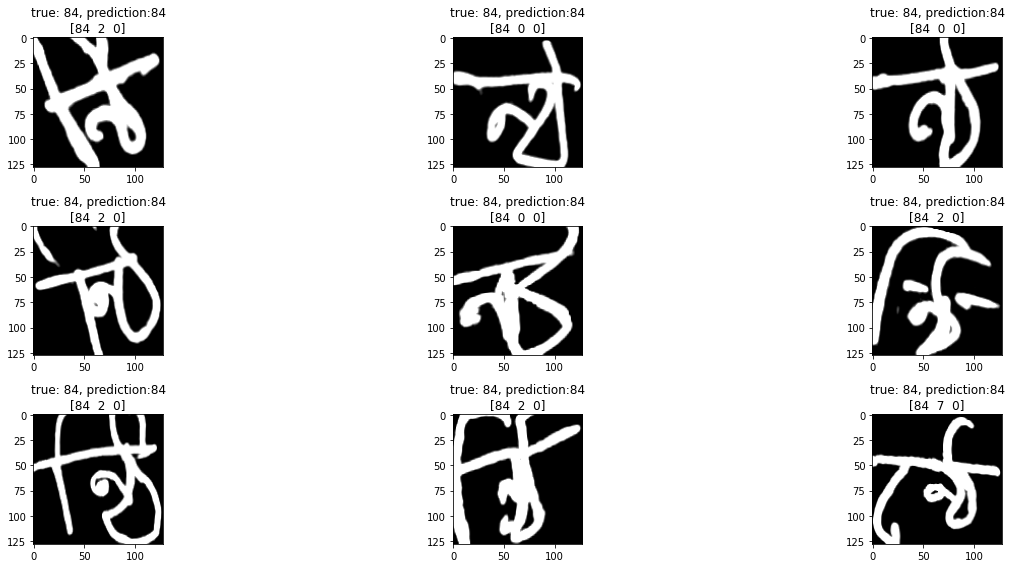


0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
0it [00:00, ?it/s]


IndexError: index 7 is out of bounds for axis 0 with size 7

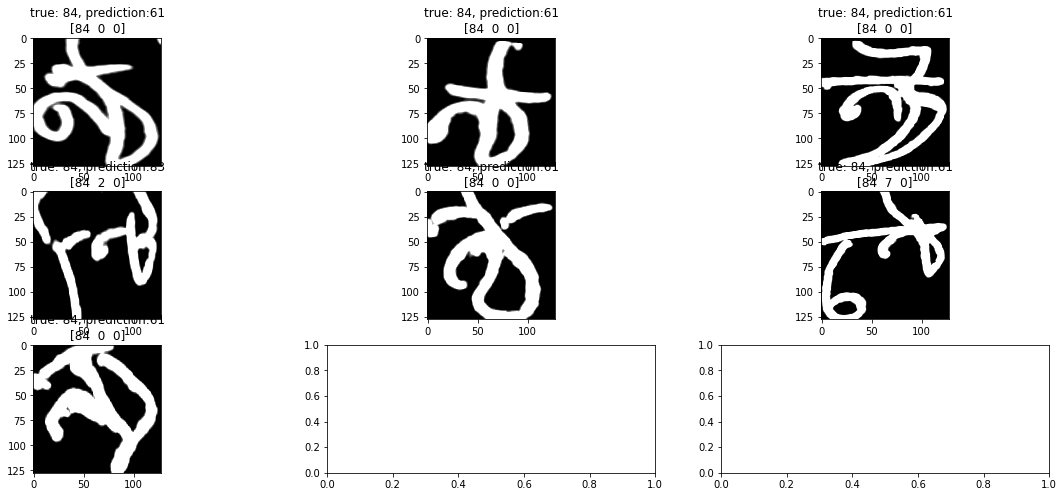

In [186]:
label2 = 84

subset_df = combined_df[combined_df['true_label']==label2]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label2 = train_dataset[i]
    image = np.einsum('ijk->jki', image)
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label2))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label2 = train_dataset[i]
    image = np.einsum('ijk->jki', image)
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label2))
plt.tight_layout()
plt.show()

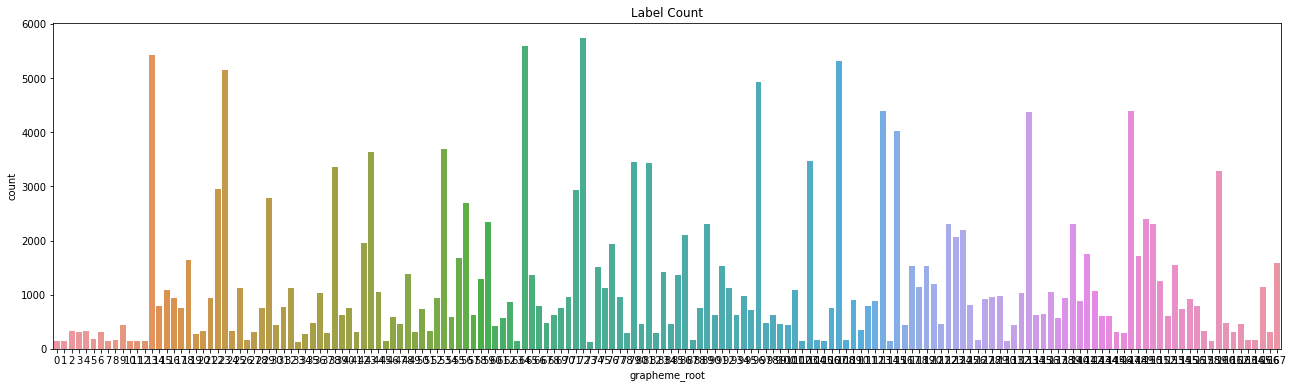

In [187]:
fig, axes = plt.subplots(1, 1, figsize=(22, 6))
plt.title('Label Count')
sns.countplot(x="grapheme_root",data=train)


0it [00:00, ?it/s]


TypeError: 'numpy.ndarray' object is not callable

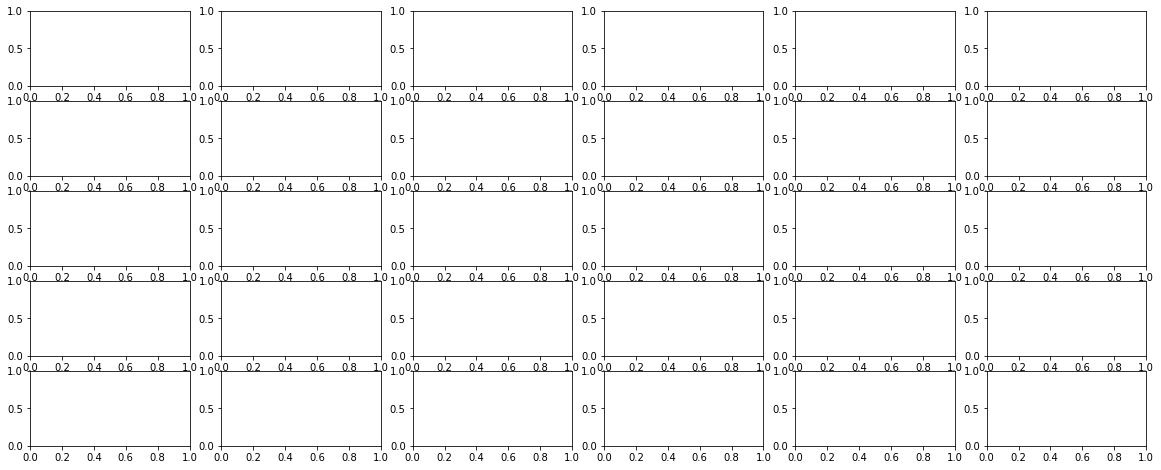

In [192]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()
plt.show()

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>